# 2D MT Inversion: MSE vs OT (Three-Block Model)

**What this notebook does:** Runs 2D MT inversion on synthetic data with a three-block model (5–10 km depth):
- Left: high resistivity (1000 Ohm·m)
- Center: low resistivity (1 Ohm·m)
- Right: high resistivity (1000 Ohm·m)

**Effect:** Compare MSE and OT (Sinkhorn) data loss approaches on the same three-block geometry.

## 1. Setup: Imports, Device, Grid & Model (Shared)

In [1]:
import sys
import os

# Ensure repo root is on path (works when run from tests/test_mt2d or repo root)
for _root in [os.getcwd(), os.path.join(os.getcwd(), ".."), os.path.join(os.getcwd(), "..", "..")]:
    if os.path.exists(os.path.join(_root, "src", "mt2d_inv")):
        if _root not in sys.path:
            sys.path.insert(0, _root)
        break

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.mt2d_inv import MT2DInverter, MT2DInverterWeightedCost, MT2DTrueModels

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

# Frequencies and stations (shared)
freqs = torch.logspace(0.5, -4, 20)
stations = torch.linspace(-15000, 15000, 31)

# Grid: 0–20 km depth, -20~20 km lateral (three-block at 5–10 km)
nza = 10
z_air = -np.logspace(np.log10(10), np.log10(50000), nza)
z_air = np.flip(z_air)
z_air = np.append(z_air, 0)
z_shallow = np.logspace(np.log10(100), np.log10(8000), 14)
z_deep = np.logspace(np.log10(9000), np.log10(100000), 12)
z_sub = np.concatenate([z_shallow, z_deep])
zn = np.concatenate([z_air[:-1], np.array([0]), z_sub])

y_center = np.linspace(-20000, 20000, 41)
y_left = -np.logspace(np.log10(21000), np.log10(50000), 8)
y_right = np.logspace(np.log10(21000), np.log10(50000), 8)
y_left = np.flip(y_left)
yn = np.concatenate([y_left, y_center, y_right])

# True model: create_three_block_5_10km returns (yn, zn, nza, sig_true)
yn, zn, nza, sig_true = MT2DTrueModels.create_three_block_5_10km(
    zn, yn, nza=nza, device=device,
    bg_sigma=0.01, high_rho=1000.0, low_rho=1.0,
)
print(f"Grid: {len(zn)-1} x {len(yn)-1} cells")

Running on cuda
Grid: 36 x 56 cells


## 2. MSE Inversion

✓ Random seed set: 123
✓ 创建Sinkhorn损失:
  - p: 2, blur: 0.01, scaling: 0.9, diameter: 2.0
  - reach: None (平衡/强约束)
✓ Sinkhorn OT Loss initialized: p=2, blur=0.01, scale=0.9, reach=None, backend=tensorized
Generating 2D MT synthetic data...
✓ XY mode error propagation completed
   rho(log10) noise mean: 0.0087
   phi(normalized) noise mean: 0.0064
✓ YX mode error propagation completed
   rho(log10) noise mean: 0.0087
   phi(normalized) noise mean: 0.0064
✓ 2D data error propagation completed
Computing data weights (Target Noise: 1.0%)
  - Resistivity Error Floor: 1.0%
  - Phase Error Floor:       0.500 deg
✓ Synthetic data generated
  -> Impedance noise level: 1.0% (gaussian)
✓ Model initialization complete: Uniform.
  - Air layer fixed: nza=10, air_sigma=1.00e-10 S/m


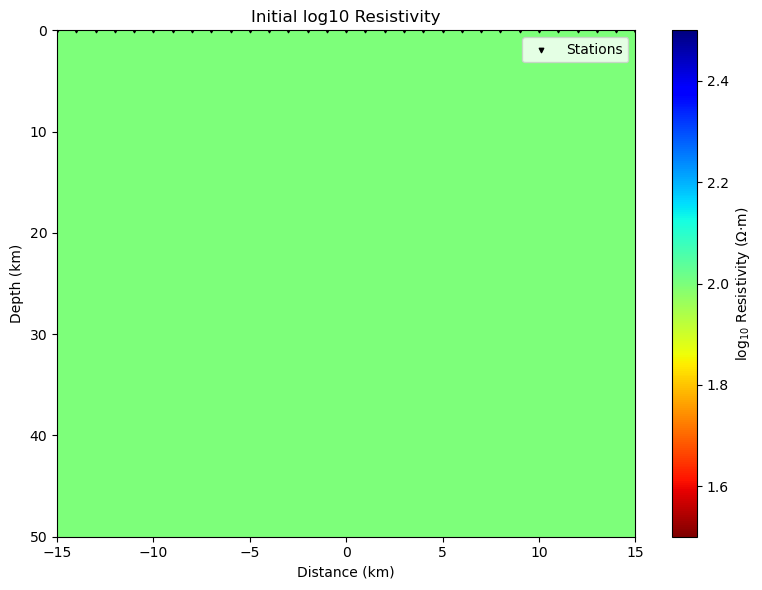

In [2]:
# Create MSE inverter
inverter_mse = MT2DInverter(
    nza=nza,
    yn=torch.tensor(yn, device=device),
    zn=torch.tensor(zn, device=device),
    freqs=freqs.to(device),
    stations=stations.to(device),
    device=device,
    random_seed=123,
)
inverter_mse.set_forward_operator()

# Set true model and generate synthetic data (1% noise)
inverter_mse.sig_true = sig_true
inverter_mse.create_synthetic_data(noise_level=0.01)

# Initialize inversion model
inverter_mse.initialize_model(initial_sigma=0.01)
inverter_mse.plot_initial_model()

In [3]:
# Run MSE inversion
final_sigma_mse = inverter_mse.run_inversion(
    n_epochs=1000,
    mode="mse",
    progress_interval=10,
    current_lambda=10,
    use_adaptive_lambda=True,
    lr=0.03,
    update_interval=10,
    norm_type="L2",
    alpha=0.5,
    use_depth_weights=True,
    rms_chi2_stop=1.03,
)
print("MSE inversion completed.")

✓ 创建优化器: AdamW
  - 学习率: 0.03
  - 权重衰减: 0.0
Epoch 1/1000 [   0.1%]
  Elapsed: 0:00:03 | Remaining: ~0:41:16 | ETA: 15:54:04
  Epoch time: 2.48s | Avg: 2.48s
  Total: 9.3817e+01 | Data(mse): 9.3817e+01
  Misfit(RMS χ²): 9.686 | Rough: 0.00e+00 | Lam: 10.0000000
  GradNorms: |g_d|=7.030e-01 | |g_m|=1.000e-12
Epoch 11/1000 [   1.1%]
  Elapsed: 0:00:26 | Remaining: ~0:37:58 | ETA: 15:51:09
  Epoch time: 2.29s | Avg: 2.30s
  Total: 5.4704e+01 | Data(mse): 5.4690e+01
  Misfit(RMS χ²): 7.395 | Rough: 1.31e-03 | Lam: 10.0000000
  GradNorms: |g_d|=2.127e-01 | |g_m|=9.906e-05
Epoch 21/1000 [   2.1%]
  Elapsed: 0:00:49 | Remaining: ~0:37:26 | ETA: 15:51:00
  Epoch time: 2.28s | Avg: 2.30s
  Total: 4.0338e+01 | Data(mse): 4.0285e+01
  Misfit(RMS χ²): 6.347 | Rough: 5.33e-03 | Lam: 10.0000000
  GradNorms: |g_d|=8.132e-02 | |g_m|=1.869e-04
Epoch 31/1000 [   3.1%]
  Elapsed: 0:01:11 | Remaining: ~0:36:57 | ETA: 15:50:54
  Epoch time: 2.27s | Avg: 2.29s
  Total: 3.3755e+01 | Data(mse): 3.3627e+01
  Mis

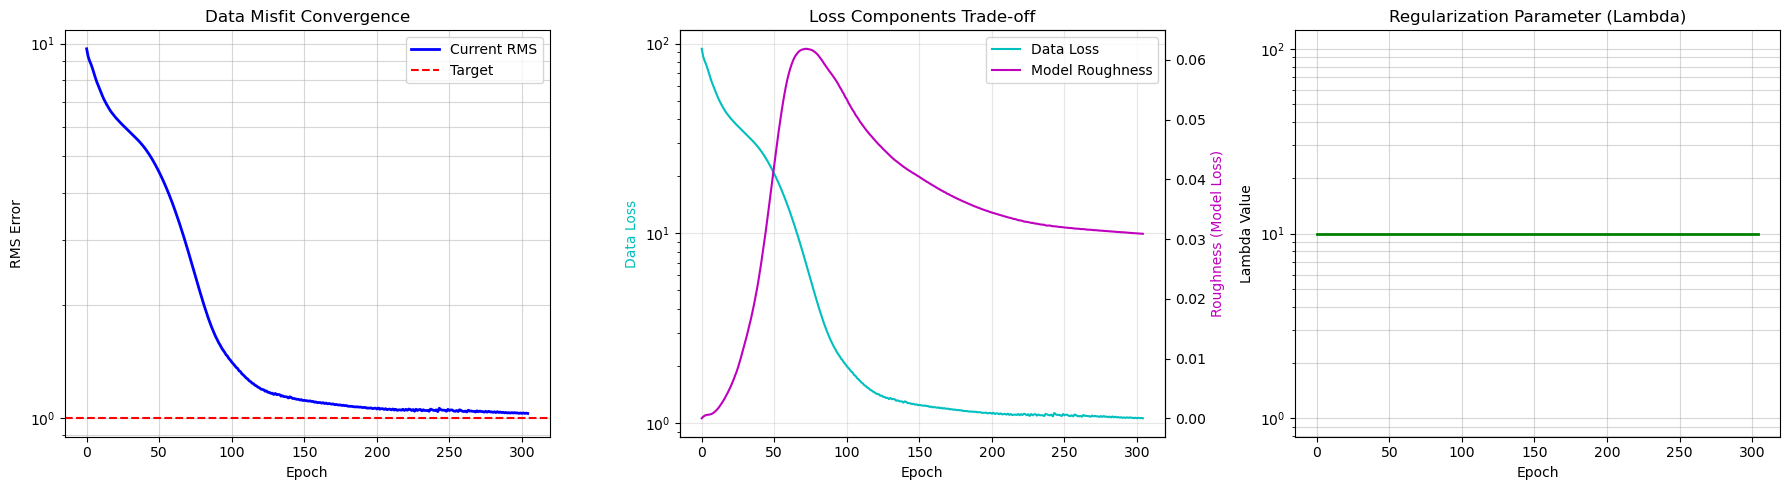

Model structural similarity (SSIM): 0.9373


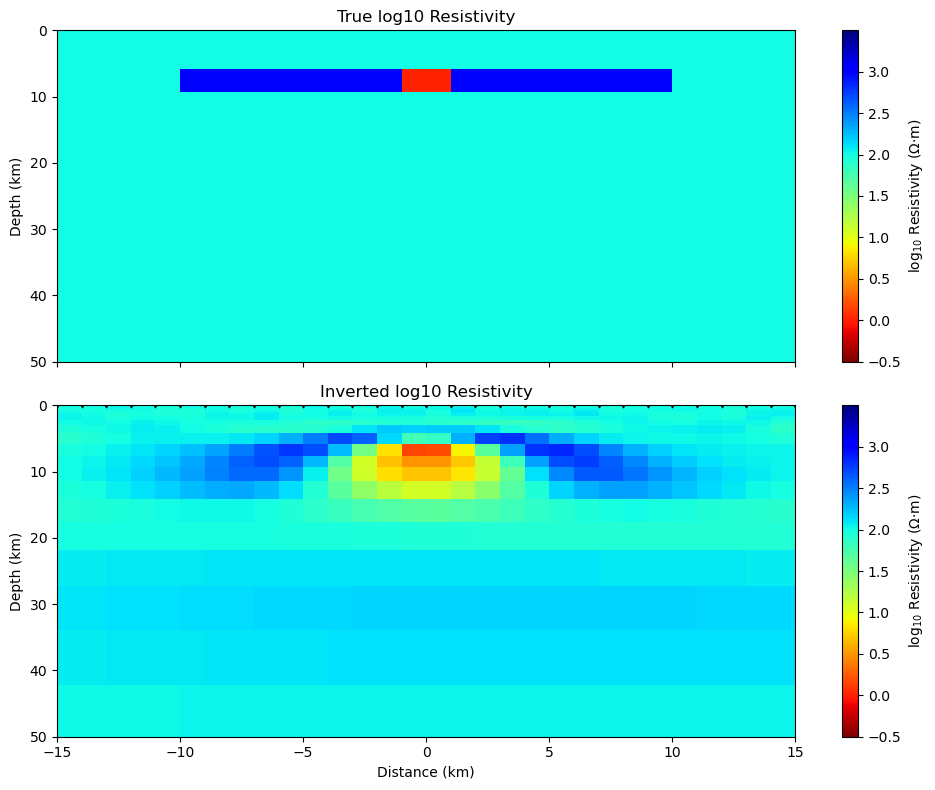

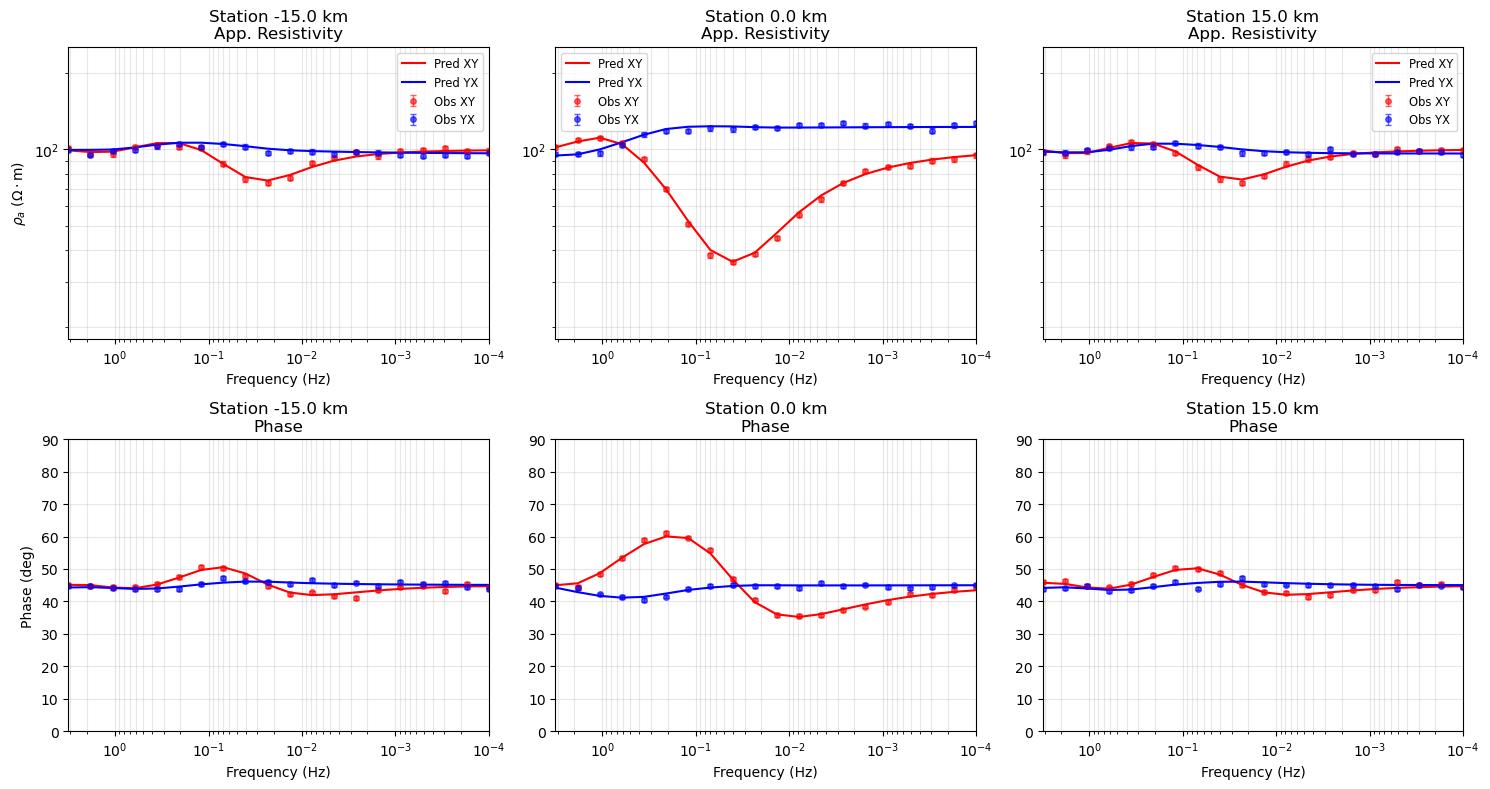

In [4]:
# MSE output
inverter_mse.plot_loss_history()
inverter_mse.plot_model_comparison(cmap="jet_r", xlim=[-15, 15], ylim=[50, 0])
inverter_mse.plot_data_fitting()


## 3. OT Inversion (Sinkhorn Weighted Cost)

✓ Random seed set: 123
✓ 创建Sinkhorn损失 (自定义 cost): blur=0.01, scaling=0.9
✓ Sinkhorn OT Loss (加权成本): w_s=1.0, w_f=1.0, w_d=10, blur=0.01, scale=0.9, reach=0.05
Generating 2D MT synthetic data...
✓ XY mode error propagation completed
   rho(log10) noise mean: 0.0087
   phi(normalized) noise mean: 0.0064
✓ YX mode error propagation completed
   rho(log10) noise mean: 0.0087
   phi(normalized) noise mean: 0.0064
✓ 2D data error propagation completed
Computing data weights (Target Noise: 1.0%)
  - Resistivity Error Floor: 1.0%
  - Phase Error Floor:       0.500 deg
✓ Synthetic data generated
  -> Impedance noise level: 1.0% (gaussian)
✓ Model initialization complete: Uniform.
  - Air layer fixed: nza=10, air_sigma=1.00e-10 S/m

OT 各维度贡献诊断 E[(Δx_k)²]
  k=0 freq(norm)      : E[(Δx_k)²] = 0.000000e+00
         pred 范围 [0.0000, 1.0000]  obs 范围 [0.0000, 1.0000]
  k=1 station(norm)   : E[(Δx_k)²] = 0.000000e+00
         pred 范围 [0.0000, 1.0000]  obs 范围 [0.0000, 1.0000]
  k=2 rhoxy           : E[(

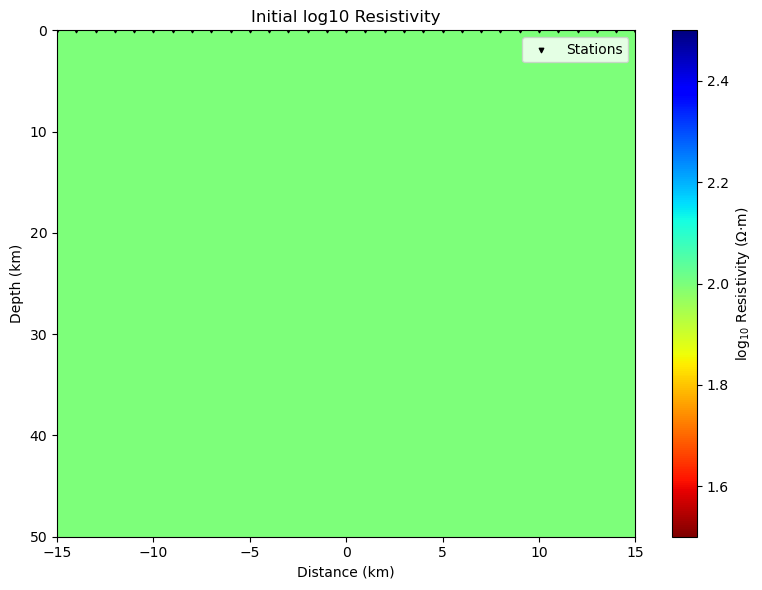

In [5]:
# Create OT inverter
inverter_ot = MT2DInverterWeightedCost(
    nza=nza,
    yn=torch.tensor(yn, device=device),
    zn=torch.tensor(zn, device=device),
    freqs=freqs.to(device),
    stations=stations.to(device),
    device=device,
    random_seed=123,
    ot_options={
        "w_s": 1.0,
        "w_f": 1.0,
        "w_d": 10,
        "blur": 0.01,
        "reach": 0.05,
    },
)
inverter_ot.set_forward_operator()

# Set true model and generate synthetic data (1% noise)
inverter_ot.sig_true = sig_true
inverter_ot.create_synthetic_data(noise_level=0.01)

# Initialize inversion model
inverter_ot.initialize_model(initial_sigma=0.01)
inverter_ot.print_ot_dimension_contributions()
inverter_ot.plot_initial_model()

In [6]:
# Run OT inversion
final_sigma_ot = inverter_ot.run_inversion(
    n_epochs=1000,
    mode="6dot",
    progress_interval=10,
    current_lambda=10,
    use_adaptive_lambda=True,
    lr=0.03,
    update_interval=10,
    norm_type="L2",
    alpha=0.5,
    use_depth_weights=True,
    rms_chi2_stop=1.03,
)
print("OT inversion completed.")

✓ 创建优化器: AdamW
  - 学习率: 0.03
  - 权重衰减: 0.0
Epoch 1/1000 [   0.1%]
  Elapsed: 0:00:02 | Remaining: ~0:38:18 | ETA: 16:02:41
  Epoch time: 2.30s | Avg: 2.30s
  Total: 3.5033e-01 | Data(6dot): 3.5033e-01
  Misfit(RMS χ²): 9.686 | Rough: 0.00e+00 | Lam: 10.0000000
  GradNorms: |g_d|=4.404e-03 | |g_m|=1.000e-12
 [Auto-Lambda] Epoch 10: Adjusted 1.00e+01 -> 4.43e+00
Epoch 11/1000 [   1.1%]
  Elapsed: 0:00:25 | Remaining: ~0:37:55 | ETA: 16:02:42
  Epoch time: 2.29s | Avg: 2.30s
  Total: 2.8559e-01 | Data(6dot): 2.7814e-01
  Misfit(RMS χ²): 8.223 | Rough: 1.68e-03 | Lam: 4.4328327
  GradNorms: |g_d|=2.043e-03 | |g_m|=3.528e-04
 [Auto-Lambda] Epoch 20: Adjusted 4.43e+00 -> 2.75e+00
Epoch 21/1000 [   2.1%]
  Elapsed: 0:00:48 | Remaining: ~0:37:28 | ETA: 16:02:38
  Epoch time: 2.31s | Avg: 2.30s
  Total: 2.6395e-01 | Data(6dot): 2.5787e-01
  Misfit(RMS χ²): 7.319 | Rough: 2.21e-03 | Lam: 2.7490731
  GradNorms: |g_d|=7.311e-04 | |g_m|=1.925e-04
 [Auto-Lambda] Epoch 30: Adjusted 2.75e+00 -> 2.12e+

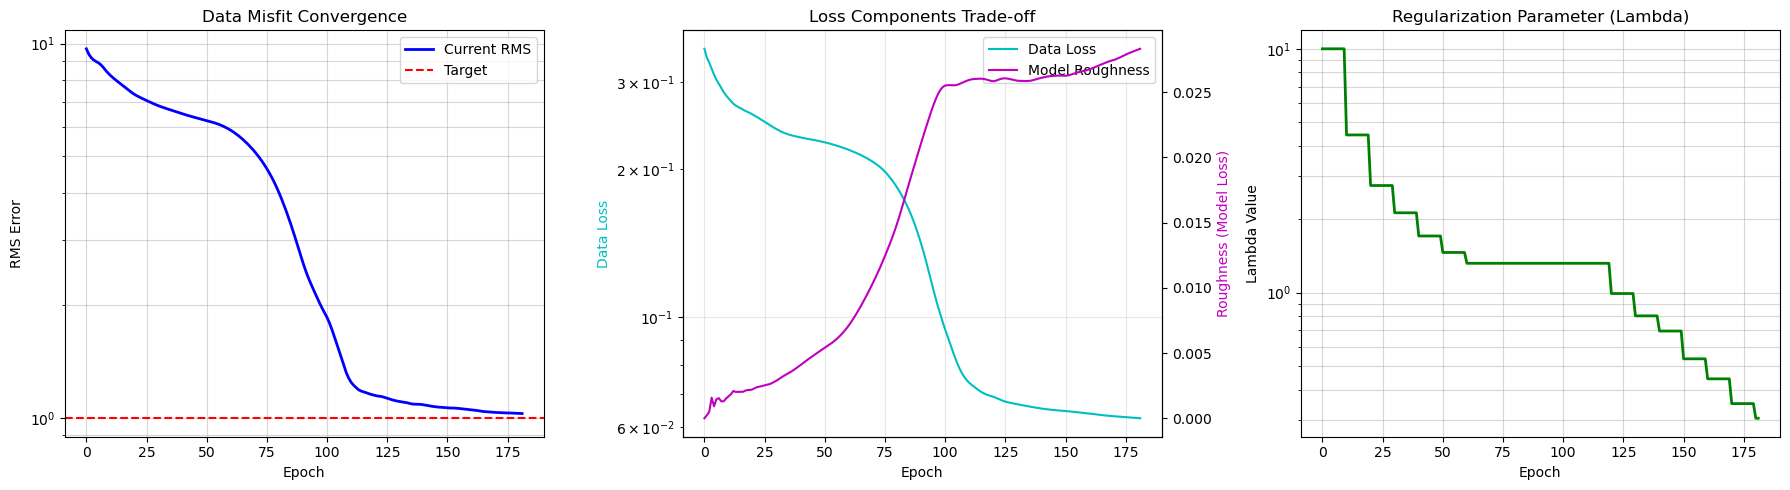

Model structural similarity (SSIM): 0.9473


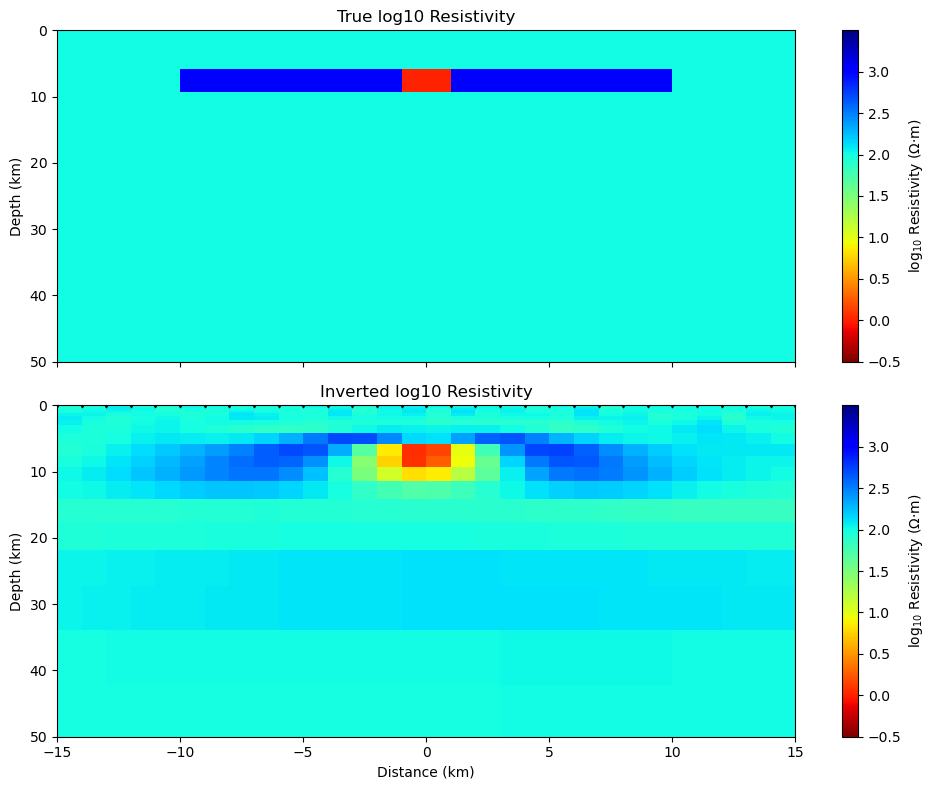

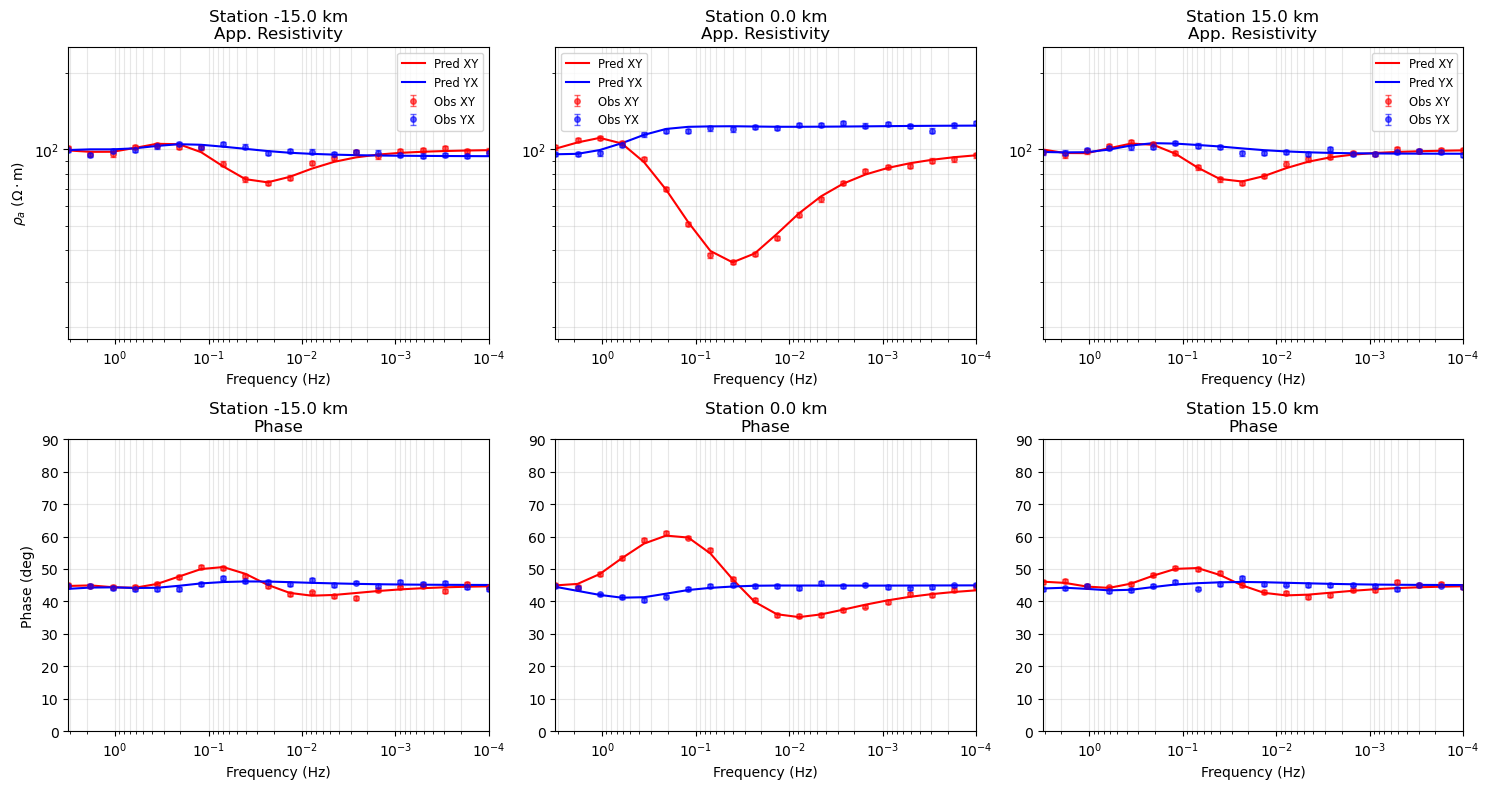

In [7]:
# OT output
inverter_ot.plot_loss_history()
inverter_ot.plot_model_comparison(cmap="jet_r", xlim=[-15, 15], ylim=[50, 0])
inverter_ot.plot_data_fitting()